# Tema 1 - Clasificare de Imagini
Mîrza Ana-Maria 341C1

Scopul acestei teme este de a explora modalități de clasificare a imaginilor prin compararea diferitelor modele de antrenare și a extragerilor de atribute. Pentru rezolvarea temei se vor urma următorii pași:
* Vizualizarea și "explorarea" datelor
* Extragerea atribuțiilor din setul de date
* Evaluarea mai multor modele pentru găsirea soluției celei mai bune pentru problema dată

## Setul de date
Vom lucra cu seturile de date [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) și [Fruits-360](https://www.kaggle.com/datasets/moltean/fruits), un set de date RGB cu 70 de tipuri diferite de fructe, legume și nuci. Fashion-MNIST conține imagini cu articole vestimentare în format greyscale. Etichetele din setul de date Fashion-MNIST sunt:

Label - Description 

0  - T-shirt/top

1  - Trouser

2  - Pullover

3  - Dress

4  - Coat

5  - Sandal

6  - Shirt

7  - Sneaker

8  - Bag

9  - Ankle boot



## Dependinte

In [1]:
# Structuri de date și unelte de analiză
import numpy as np
import pandas as pd
import cv2
import glob
import os
import string

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn import metrics
from sklearn.svm import SVC

from skimage.transform import resize
from skimage.feature import hog

# Vizualizare
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Antrenare
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import make_scorer, precision_score, accuracy_score
import multiprocessing
from sklearn.datasets import fetch_california_housing
import xgboost as xgb

dim = 100

## Fruits-360

### Procesare Set de Date

In [57]:
def getYourFruits(fruits, data_type, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Training', 'Test']
    if not k_fold:
        path = "./input/fruits-360/" + data_type + "/"
        for i,f in enumerate(fruits):
            j=0

            paths = [path + entry.name for entry in os.scandir(path) 
                 if entry.is_dir() and entry.name.startswith(f)]
            for p in paths:
                for image_path in glob.glob(os.path.join(p, "*.jpg")):
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    image = cv2.resize(image, (dim, dim))
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    images.append(image)
                    labels.append(i)
                    j+=1
            if(print_n):
                print("There are " , j , " " , data_type.upper(), " images of " , fruits[i].upper())
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    else:
        for v in val:
            path = "./input/fruits-360/" + v + "/"
            for i,f in enumerate(fruits):
                p = path + f
                j=0

                paths = [path + entry.name for entry in os.scandir(path) 
                            if entry.is_dir() and entry.name.startswith(f)]
                for p in paths:
                    for image_path in glob.glob(os.path.join(p, "*.jpg")):
                        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                        image = cv2.resize(image, (dim, dim))
                        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                        images.append(image)
                        labels.append(i)
                        j+=1
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    
def getAllFruits():
    fruits = []
    for fruit_path in glob.glob("./input/fruits-360/Training/*"):
        fruit = fruit_path.split("/")[-1].split(" ")[0]
        if fruit not in fruits:
            fruits.append(fruit)
    return fruits

In [58]:
#Choose your Fruits
fruits = ['Pineapple' , 'Cocos', 'Carrot', 'Guava']
# fruits = getAllFruits()

#Get Images and Labels 
X_t, y_train =  getYourFruits(fruits, 'Training', print_n=True, k_fold=False)
X_testt, y_test = getYourFruits(fruits, 'Test', print_n=True, k_fold=False)

There are  983   TRAINING  images of  PINEAPPLE
There are  490   TRAINING  images of  COCOS
There are  151   TRAINING  images of  CARROT
There are  490   TRAINING  images of  GUAVA
There are  329   TEST  images of  PINEAPPLE
There are  166   TEST  images of  COCOS
There are  50   TEST  images of  CARROT
There are  166   TEST  images of  GUAVA


### Standardizarea Datelor

In [59]:
# Preprocesarea datelor
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X_t])
X_test = scaler.fit_transform([i.flatten() for i in X_testt])

print(X_t.shape)
print(X_train.shape)

(2114, 100, 100, 3)
(2114, 30000)


Pineapple


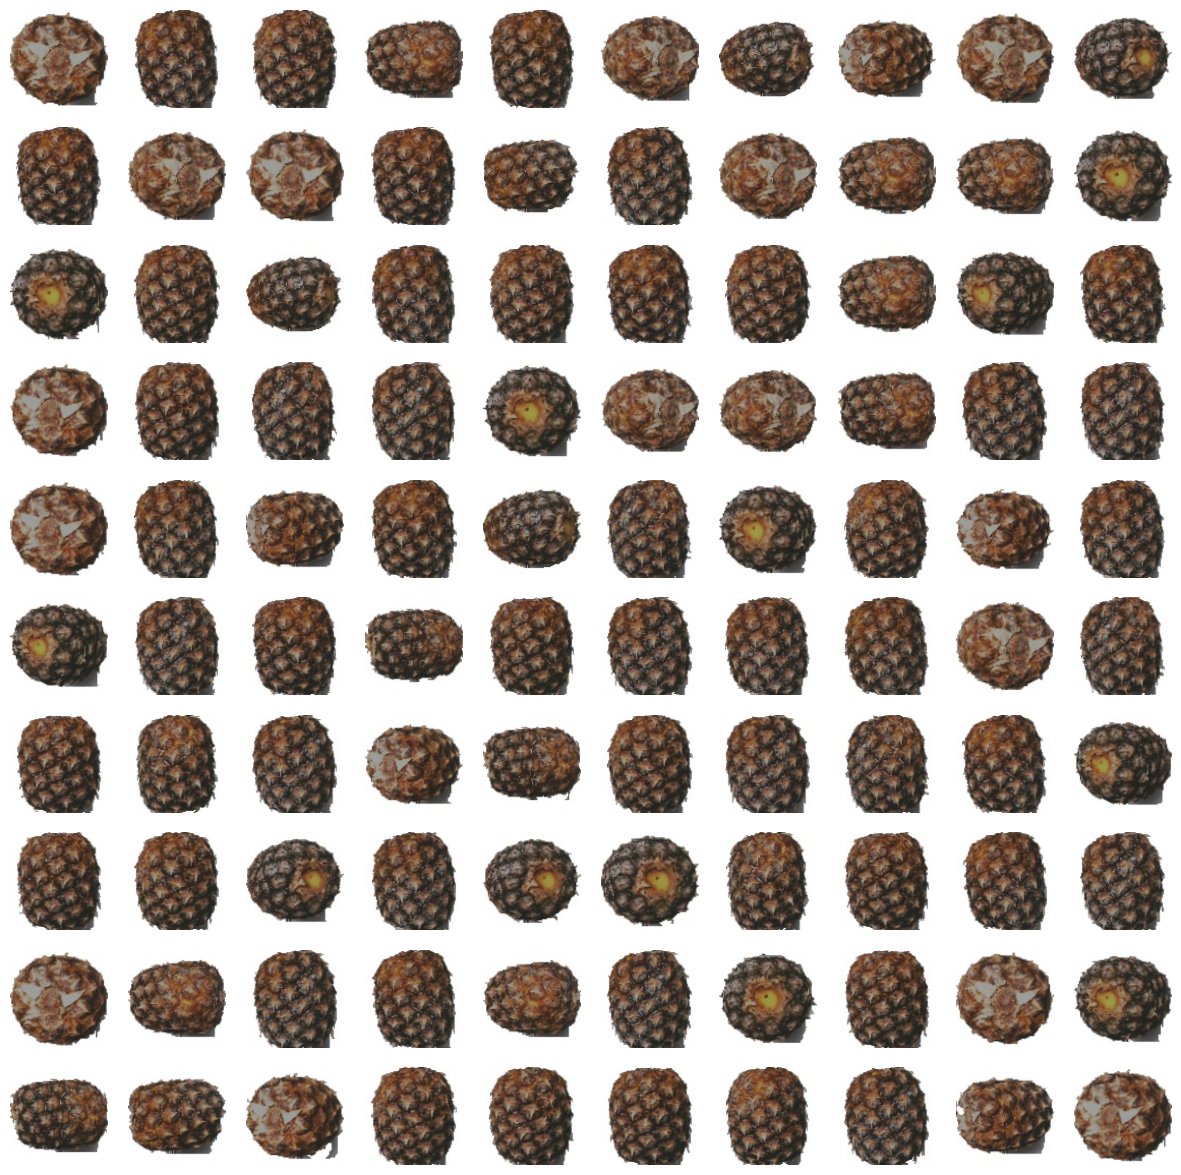

In [60]:
# Vizualizare imagini
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1

# Plotare imagini
print(fruits[y_train[0]])
plot_image_grid(X_t[0:100], 10, 10)

### Echilibrul Setului de Date

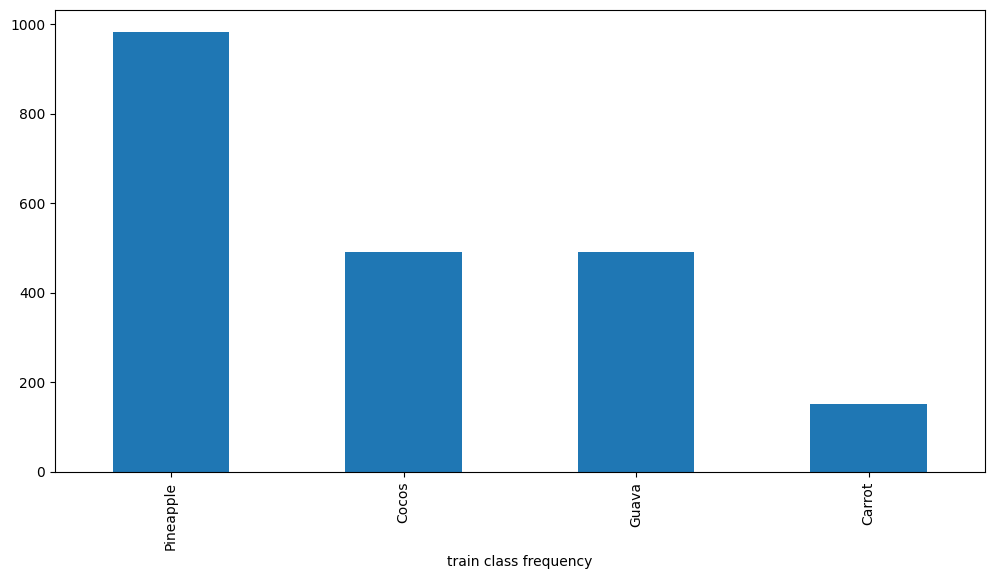

In [61]:
# Analiza echilibrului setului de date de antrenare
y_train2 = [fruits[i] for i in y_train]
df = pd.DataFrame(y_train2, columns=['train class frequency'])
df_freq = df['train class frequency'].value_counts()

ax = df_freq.plot.bar(x='train', y='frequency', rot=90, figsize=(12, 6))

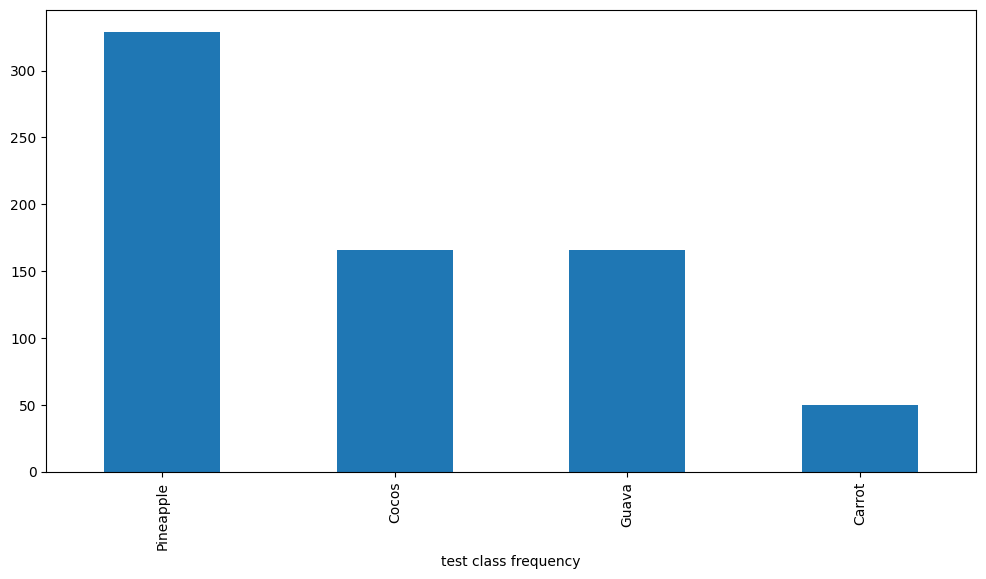

In [62]:
# Analiza echilibrului setului de date de testare
y_test2 = [fruits[i] for i in y_test]
df_test = pd.DataFrame(y_test2, columns=['test class frequency'])
df_test_freq = df_test['test class frequency'].value_counts()

ax = df_test_freq.plot.bar(x='class', y='frequency', rot=90, figsize=(12, 6))

In [63]:
# Cele mai numeroase 10 clase
print(df_freq.sort_values())
top_classes = list(df_freq.sort_values().tail(3).index)
print(f'\nTop classes: {top_classes}')

train class frequency
Carrot       151
Cocos        490
Guava        490
Pineapple    983
Name: count, dtype: int64

Top classes: ['Cocos', 'Guava', 'Pineapple']


### Extragerea Atributelor - PCA

In [64]:
def getClassNumber(y):
    v =[]
    i=0
    count = 0
    for index in y:
        if(index == i):
            count +=1
        else:
            v.append(count)
            count = 1
            i +=1
    v.append(count)        
    return v

def plotPrincipalComponents(X, dim):
    v = getClassNumber(y_train)
    colors = 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple'
    markers = ['o', 'x' , 'v', 'd']
    tot = len(X)
    start = 0 
    if(dim == 2):
        for i,index in enumerate(v):
            end = start + index
            plt.scatter(X[start:end,0],X[start:end,1] , color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i])
            start = end
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    
    if(dim == 3):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i,index in enumerate(v):
            end = start + index
            ax.scatter(X[start:end,0], X[start:end,1], X[start:end,2], color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i])
            start = end
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')


    plt.legend(loc='lower left')
    plt.xticks()
    plt.yticks()
    plt.show()
    

Aplicam PCA pe setul de date

In [65]:
# Aplicați PCA pe datele de antrenament și testare
pca = PCA(n_components=20)
X_t20 = pca.fit_transform(X_train)
X_test20 = pca.transform(X_test)

#### Vizualizarea atributiilor extrase

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1..403].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [7..309].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [18..321].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [31..306].


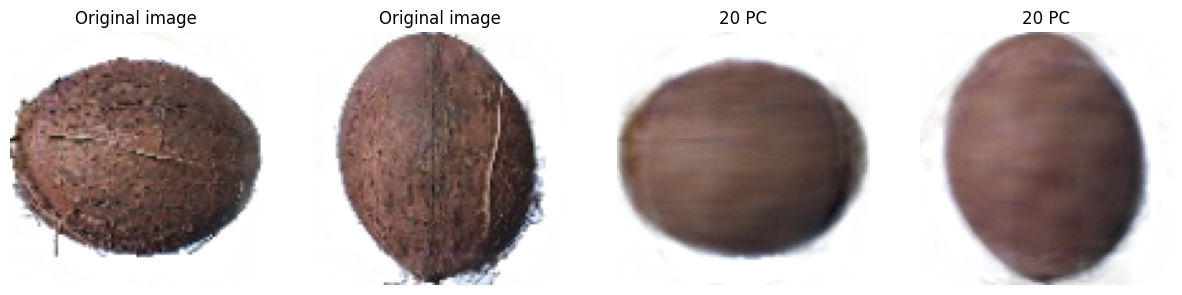

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-14..292].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-16..289].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-18..291].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2..287].


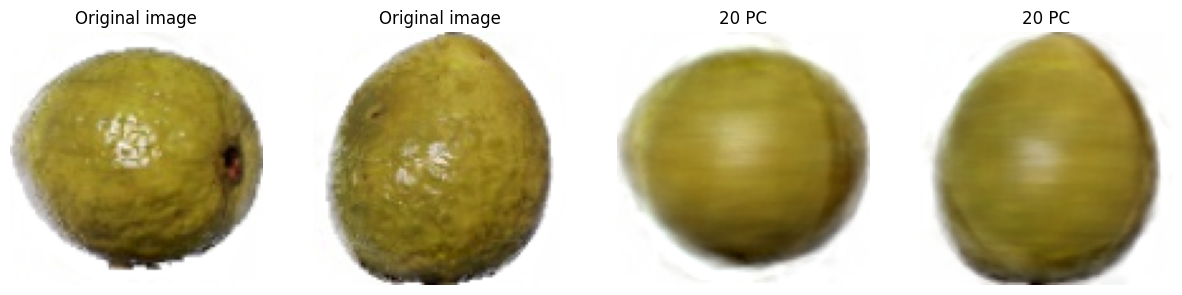

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [13..281].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7..292].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [6..278].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [14..306].


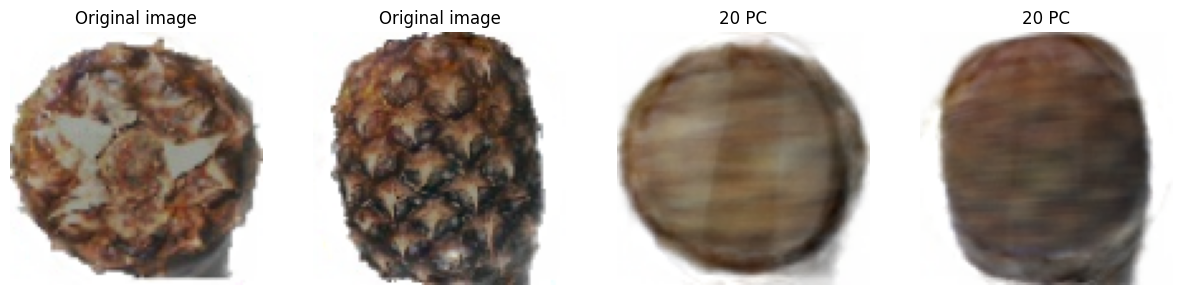

In [66]:
def showPCA(image,X2, X10, X50):
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(1,4,1)
    ax1.axis('off')
    ax1.set_title('Original image')
    plt.imshow(image, cmap='Accent')
    ax1 = fig.add_subplot(1,4,2)
    ax1.axis('off') 
    ax1.set_title('Original image')
    plt.imshow(X2)
    ax1 = fig.add_subplot(1,4,3)
    ax1.axis('off') 
    ax1.set_title('20 PC')
    plt.imshow(X10)
    ax2 = fig.add_subplot(1,4,4)
    ax2.axis('off') 
    ax2.set_title('20 PC')
    plt.imshow(X50)
    plt.show()

def computePCA(n, im_scaled, image_id):
    pca = PCA(n)
    principalComponents = pca.fit_transform(im_scaled)
    im_reduced = pca.inverse_transform(principalComponents)
    newImage = scaler.inverse_transform(im_reduced[image_id].reshape(1, -1))
    return newImage


# Vizualizare PCA pe cele mai numeroase 10 clase
for fruit in top_classes:
    index = list(y_train2).index(fruit)

    image1 = scaler.inverse_transform(X_train[index].reshape(1, -1))
    image1 = np.reshape(image1, (dim,dim,3)).astype(int)
    image2 = scaler.inverse_transform(X_train[index + 1].reshape(1, -1))
    image2 = np.reshape(image2, (dim,dim,3)).astype(int)

    image3 = pca.inverse_transform(X_t20[index])
    image3 = scaler.inverse_transform(image3.reshape(1, -1))
    image3 = np.reshape(image3, (dim,dim,3)).astype(int)
    image4 = pca.inverse_transform(X_t20[index + 1])
    image4 = scaler.inverse_transform(image4.reshape(1, -1))
    image4 = np.reshape(image4, (dim,dim,3)).astype(int)

    showPCA(image1, image2, image3, image4)

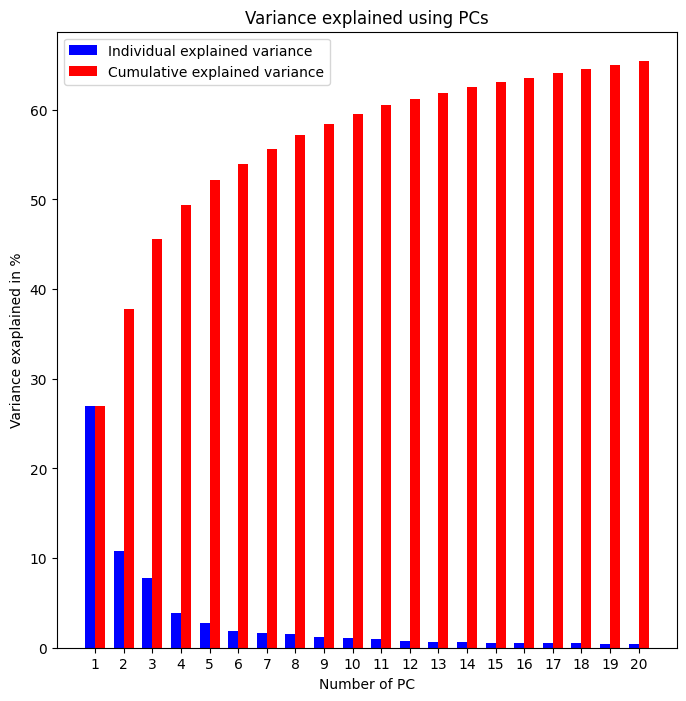

In [67]:
def showVariance(X_train):
    # Compute manually the principal components
    cov_matr=np.dot(X_train, X_train.T)
    eigval,eigvect=np.linalg.eig(cov_matr)

    index=np.argsort(eigval)[::-1] #take in order the index of ordered vector (ascending order)

    # eigvect[:,i] is associated to eigval[i] so 
    eigvect=eigvect[:,index]
    eigval=eigval[index]

    n_PC=[]
    var_explained=[]
    var_temp=[]
    var_tmp=0
    for i in range(20):
        var_tmp=var_tmp+eigval[i]
        n_PC.append(i)
        var_temp.append(eigval[i]/(eigval.sum())*100)
        var_explained.append(var_tmp/(eigval.sum())*100)

    fig, ax = plt.subplots(figsize=(8,8))

    ind = np.arange(20)    
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, var_temp, width, color='b')
    p2 = ax.bar(ind + width, var_explained, width, color='r')

    ax.legend((p1[0], p2[0]), ('Individual explained variance', 'Cumulative explained variance'))

    ax.set_title('Variance explained using PCs')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'))

    plt.xlabel('Number of PC')
    plt.ylabel('Variance exaplained in %')

    ax.autoscale_view()

    plt.show()

# Plotarea viariantei
showVariance(X_train)

### Extragerea Atributelor - HOG 

In [68]:
# Vizualizare atribute extrase
def showHOG(X_train, X_resized, X_hog, index):
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow(X_train[index])
    plt.title("original")
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(X_resized[index])
    plt.title("resized")
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(X_hog[index], cmap="gray")
    plt.title("hog")
    plt.show()

# Redimensionarea unei imagini
def resize_image(img):
    resized_img = resize(img, (128, 64))
    return resized_img

# Aplicarea algoritmului hog unei imagini
def apply_hog(resized_img):
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    return fd, hog_image


In [69]:
# Aplcare HOG pe setul de antrenament
X_trainHOG = []
images = []
hog_images = []
img_labels = []
i = 0

for image in X_t:
    resized = resize_image(image)
    fd, hog_image = apply_hog(resized)
    X_trainHOG.append(fd)

    # Vizualizare atribute extrase
    if len(images) < 10 and y_train[i] not in img_labels:
        images.append(image)
        img_labels.append(y_train[i])
        hog_images.append(hog_image)
    i += 1

X_trainHOG = np.array(X_trainHOG)
images = np.array(images)
hog_images = np.array(hog_images)

# Aplicare HOG pe setul de testare
X_testHOG = []
for image in X_testt:
    resized = resize_image(image)
    fd, _ = apply_hog(resized)
    X_testHOG.append(fd)

X_testHOG = np.array(X_testHOG)

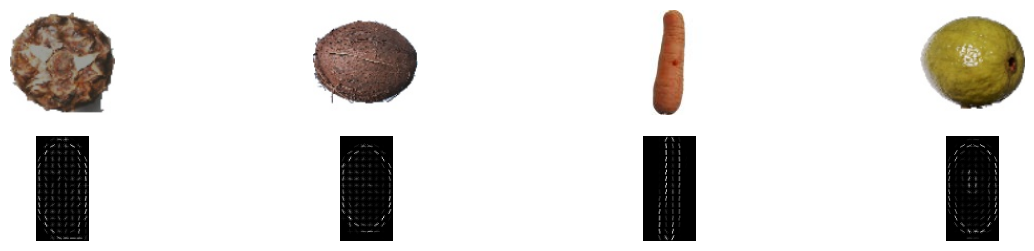

In [70]:
# Vizualizare pe cele mai numeroase clase
size = len(images)
fig, axs = plt.subplots(2, size, figsize=(15, 3))

for i in range(size):
    axs[0, i].axis('off')
    axs[0, i].imshow(images[i])
    axs[1, i].axis('off')
    axs[1, i].imshow(hog_images[i], cmap="gray")

### Selectia Atributelor

In [71]:
sel = VarianceThreshold(threshold=(0.01))
sel_percentile = SelectPercentile(chi2, percentile=80)
sel_percentile2 = SelectPercentile(percentile=80)

print(f'PCA: X shape before applying variance threashold: {X_t20.shape}')
X_t20_scaled = sel.fit_transform(X_t20)
print(f'PCA: X shape after applying variance threashold: {X_t20_scaled.shape}')
X_t20_scaled = sel_percentile2.fit_transform(X_t20, y_train)
X_test20_scaled = sel_percentile2.fit_transform(X_test20, y_test)
print(f'PCA: X shape after applying percentile selector: {X_t20_scaled.shape}')

print(f'\nHOG: X shape before applying variance threashold: {X_trainHOG.shape}')
X_trainHOG_scaled = sel.fit_transform(X_trainHOG)
X_testHOG_scaled = sel.transform(X_testHOG)
print(f'HOG: X shape after applying variance selector: {X_trainHOG_scaled.shape}')

PCA: X shape before applying variance threashold: (2114, 20)
PCA: X shape after applying variance threashold: (2114, 20)
PCA: X shape after applying percentile selector: (2114, 16)

HOG: X shape before applying variance threashold: (2114, 3780)
HOG: X shape after applying variance selector: (2114, 852)


In [72]:
# Impartirea setului de date
X_train_final_hog, X_validation_hog, y_train_final_hog, y_validation_hog = train_test_split(X_trainHOG_scaled, y_train) 
X_train_final_pca, X_validation_pca, y_train_final_pca, y_validation_pca = train_test_split(X_t20_scaled, y_train) 


### Antrenarea Modelelor

#### Antrenare modele folosind atributele PCA

In [73]:
# Logistic Regression + PCA
clf = LogisticRegression(max_iter=200)
clf = clf.fit(X_t20_scaled, y_train)
test_predictions = clf.predict(X_test20_scaled)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with Logistic Regression considering first 20PC: {0:.2f}%".format(precision))

# SVM + PCA
svm = SVC()
svm = svm.fit(X_t20_scaled, y_train) 
test_predictions = svm.predict(X_test20_scaled)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with SVM considering first 20PC: {0:.2f}%".format(precision))

# Random Forest + PCA
random_forest = RandomForestClassifier()
random_forest = random_forest.fit(X_t20_scaled, y_train)
test_predictions = random_forest.predict(X_test20_scaled)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with Random Forest considering first 20PC: {0:.2f}%".format(precision))

# Gradient Boosted Trees + PCA
xgb_model = xgb.XGBClassifier(
        n_jobs=multiprocessing.cpu_count()
    )
xgb_model.fit(X_t20_scaled, y_train)
test_predictions = xgb_model.predict(X_test20_scaled)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with Gradient Boosted Trees considering first 20PC: {0:.2f}%".format(precision))

Accuracy with Logistic Regression considering first 20PC: 94.51%
Accuracy with SVM considering first 20PC: 97.89%
Accuracy with Random Forest considering first 20PC: 97.05%
Accuracy with Gradient Boosted Trees considering first 20PC: 92.97%


##### Logistic Regression

In [74]:
# Hyperparameter Tunning
param_grid = [
    {'penalty':['l1','l2'],
    'C' : [0.1, 1, 0.01],
    'solver': ['liblinear'],
    'max_iter'  : [500, 1000],
    'multi_class' : ['ovr']
    },
    {'penalty':['l2'],
    'C' : [0.1, 1, 0.01],
    'solver': ['lbfgs', 'newton-cg', 'sag'],
    'max_iter'  : [500, 1000],
    'multi_class' : ['ovr', 'multinomial']
    },
    {'penalty':['elasticnet'],
    'C' : [0.1, 1, 0.01],
    'solver': ['saga'],
    'max_iter'  : [500, 1000],
    'l1_ratio' : [0, 0.1, 0.5],
    'multi_class' : ['ovr', 'multinomial']
    }
]

grid = GridSearchCV(LogisticRegression(), param_grid, scoring='accuracy', n_jobs=-1)
grid.fit(X_validation_pca, y_validation_pca)

# Training model
model = grid.best_estimator_
model.fit(X_train_final_pca, y_train_final_pca)
y_pred = model.predict(X_test20_scaled)

/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: Future

In [75]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Logistic Regression considering first 20PC: {0:.2f}% \n".format(precision))

Accuracy with Logistic Regression considering first 20PC: 95.22% 



In [76]:
# Defining custom function which returns
def highlight_max(s): 
    is_max = s == s.max() 
    return ['color: green; font-weight: bold;' if cell else '' for cell in is_max] 

# Tabel cu parametrii
df = pd.DataFrame(grid.cv_results_)
df = df[['param_penalty', 'param_C', 'param_solver', 'param_max_iter', 'param_multi_class', 'mean_test_score']]
df = df.sort_values(by='mean_test_score', ascending=False)

# Aplicare highlight
df_styled = df.style.apply(highlight_max).hide(axis="index")
df_styled

In [77]:
# Tabel cu metrici de performanță
target_names = fruits
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Pineapple       0.94      0.96      0.95       329
       Cocos       0.91      0.89      0.90       166
      Carrot       1.00      1.00      1.00        50
       Guava       1.00      0.99      1.00       166

    accuracy                           0.95       711
   macro avg       0.96      0.96      0.96       711
weighted avg       0.95      0.95      0.95       711



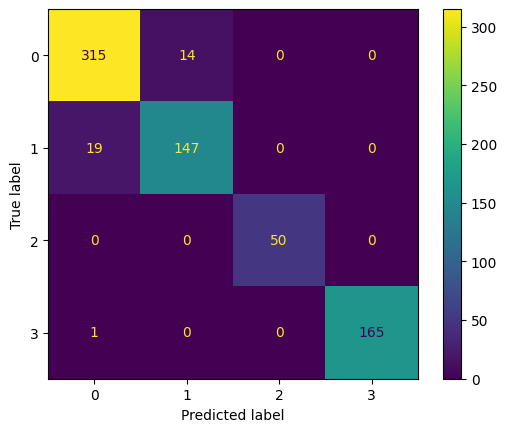

In [78]:
# Matrice de confuzie
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

##### SVM

In [79]:
# Hyperparameter Tunning
param_grid = {'C': [0.01, 0.1, 1, 10],  
              'gamma': ['scale', 'auto'], 
              'kernel': ['poly', 'rbf'],
              'random_state': [0, 16, 19, None] 
            }
grid = GridSearchCV(SVC(), param_grid, refit = True, scoring='accuracy', n_jobs=-1)
grid.fit(X_validation_pca, y_validation_pca)

# Training model
model = grid.best_estimator_
model.fit(X_train_final_pca, y_train_final_pca)
y_pred = model.predict(X_test20_scaled)

In [80]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM considering first 20PC: {0:.2f}%".format(precision))

Accuracy with SVM considering first 20PC: 94.37%


In [81]:
def highlight_max(s): 
    is_max = s == s.max() 
    return ['color: green; font-weight: bold;' if cell else '' for cell in is_max] 

# Tabel cu parametrii
df = pd.DataFrame(grid.cv_results_)
df = df[['param_C', 'param_gamma', 'param_kernel', 'param_random_state', 'mean_test_score']]
df = df.sort_values(by='mean_test_score', ascending=False)

# Aplicare highlight
df_styled = df.style.apply(highlight_max).hide(axis="index")
df_styled

In [82]:
# Tabel cu metrici de performanță
target_names = fruits
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Pineapple       0.90      0.98      0.94       329
       Cocos       0.96      0.80      0.87       166
      Carrot       1.00      1.00      1.00        50
       Guava       1.00      1.00      1.00       166

    accuracy                           0.94       711
   macro avg       0.97      0.94      0.95       711
weighted avg       0.95      0.94      0.94       711



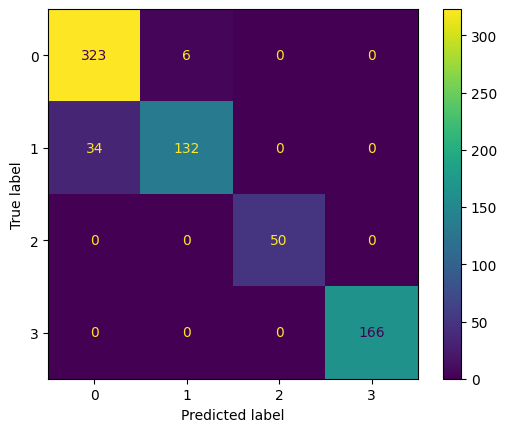

In [83]:
# Matrice de confuzie
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

##### Random Forest

In [84]:
# Hyperparameter Tunning
param_grid = { 
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 8, 12, 15, None],
    'max_samples': [0.3, 0.7, 1.0, None]
} 

grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring='accuracy', n_jobs=-1)
grid.fit(X_validation_pca, y_validation_pca)

# Training model
model = grid.best_estimator_
model = model.fit(X_train_final_pca, y_train_final_pca)
y_pred = model.predict(X_test20_scaled)

In [85]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Random Forest considering first 20PC: {0:.2f}%".format(precision))

Accuracy with Random Forest considering first 20PC: 97.05%


In [86]:
def highlight_max(s): 
    is_max = s == s.max() 
    return ['color: green; font-weight: bold;' if cell else '' for cell in is_max] 

# Tabel cu parametrii
df = pd.DataFrame(grid.cv_results_)
df = df[['param_n_estimators', 'param_max_depth', 'param_max_samples', 'mean_test_score']]
df = df.sort_values(by='mean_test_score', ascending=False)

# Aplicare highlight
df_styled = df.style.apply(highlight_max).hide(axis="index")
df_styled

In [87]:
# Tabel cu metrici de performanță
target_names = fruits
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Pineapple       0.96      0.98      0.97       329
       Cocos       0.95      0.92      0.94       166
      Carrot       1.00      1.00      1.00        50
       Guava       1.00      1.00      1.00       166

    accuracy                           0.97       711
   macro avg       0.98      0.97      0.98       711
weighted avg       0.97      0.97      0.97       711



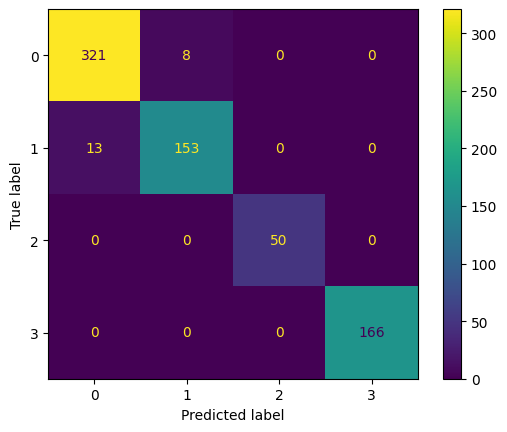

In [88]:
# Matrice de confuzie
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

##### Gradient Boosted Trees

In [ ]:
# Hyperparameter Tunning
param_grid = {
    "max_depth": [2, 4, 6], 
    "num_parallel_tree": [1, 3, 5],
    "eta": [0.15, 0.3, 0.45]
}
grid = GridSearchCV(
    xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()),
    param_grid,
    scoring='accuracy',
    n_jobs=-1,
)
grid.fit(X_validation_pca, y_validation_pca)

# Training model 
model = grid.best_estimator_
model = model.fit(X_train_final_pca, y_train_final_pca)
y_pred = model.predict(X_test20_scaled)

In [90]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Gradient Boosted Treea considering first 20PC: {0:.2f}%".format(precision))

Accuracy with Gradient Boosted Treea considering first 20PC: 94.80%


In [91]:
def highlight_max(s): 
    is_max = s == s.max() 
    return ['color: green; font-weight: bold;' if cell else '' for cell in is_max] 

# Tabel cu parametrii
df = pd.DataFrame(grid.cv_results_)
df = df[['param_max_depth', 'param_num_parallel_tree', 'param_eta', 'mean_test_score']]
df = df.sort_values(by='mean_test_score', ascending=False)

# Aplicare highlight
df_styled = df.style.apply(highlight_max).hide(axis="index")
df_styled

In [92]:
# Tabel cu metrici de performanță
target_names = fruits
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Pineapple       0.91      0.98      0.95       329
       Cocos       0.96      0.82      0.89       166
      Carrot       1.00      0.96      0.98        50
       Guava       1.00      1.00      1.00       166

    accuracy                           0.95       711
   macro avg       0.97      0.94      0.95       711
weighted avg       0.95      0.95      0.95       711



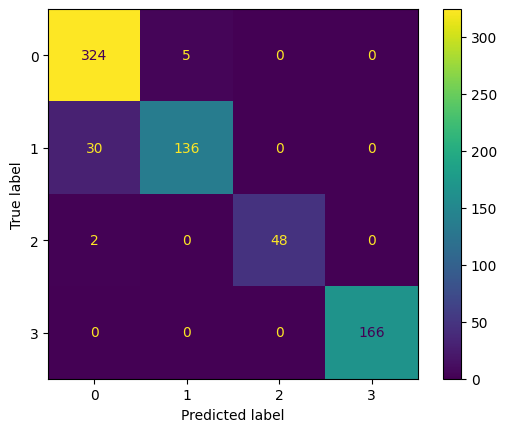

In [93]:
# Matrice de confuzie
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

#### Antrenare modele folosind atributele HOG

In [94]:
# Logistic Regression + HOG
clf = LogisticRegression()
clf = clf.fit(X_trainHOG_scaled, y_train)
test_predictions = clf.predict(X_testHOG_scaled)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with Logistic Regression and hog: {0:.2f}%".format(precision))

# SVM + HOG
svm = SVC()
svm = svm.fit(X_trainHOG_scaled, y_train) 
test_predictions = svm.predict(X_testHOG_scaled)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with SVM and hog: {0:.2f}%".format(precision))

# Random Forest + HOG
random_forest = RandomForestClassifier()
random_forest = random_forest.fit(X_trainHOG_scaled, y_train)
test_predictions = random_forest.predict(X_testHOG_scaled)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with Random Forest and hog: {0:.2f}%".format(precision))

# Gradient Boosted Trees + HOG
xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count())
xgb_model.fit(X_trainHOG_scaled, y_train)
test_predictions = xgb_model.predict(X_testHOG_scaled)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with Gradient Boosted Trees and hog: {0:.2f}%".format(precision))

Accuracy with Logistic Regression and hog: 97.89%
Accuracy with SVM and hog: 98.45%
Accuracy with Random Forest and hog: 99.86%
Accuracy with Gradient Boosted Trees and hog: 98.87%


##### Logistic Regression

In [ ]:
# Hyperparameter Tunning
param_grid = [
    {'C' : [0.2, 0.5, 1.0],
    'multi_class' : ['ovr', 'multinomial', 'auto'],
    'max_iter': [200, 300],
    'random_state': [0, 10, 16, None]
    }
]

grid = HalvingGridSearchCV(LogisticRegression(), param_grid, scoring='accuracy', n_jobs=-1)
grid = grid.fit(X_validation_hog, y_validation_hog)

# Training model
model = grid.best_estimator_
model = model.fit(X_train_final_hog, y_train_final_hog)
y_pred = model.predict(X_testHOG_scaled)

/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: Future

NameError: name 'X_testHOG_scaled1' is not defined

In [ ]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Logistic Regression and HOG: {0:.2f}%".format(precision))

Accuracy with Logistic Regression and HOG: 97.89%
{'C': 1.0, 'max_iter': 300, 'multi_class': 'multinomial', 'random_state': 0}


In [ ]:
# Defining custom function which returns
def highlight_max(s): 
    is_max = s == s.max() 
    return ['color: green; font-weight: bold;' if cell else '' for cell in is_max] 

# Tabel cu parametrii
df = pd.DataFrame(grid.cv_results_)
df = df[['param_penalty', 'param_C', 'param_solver', 'param_max_iter', 'param_multi_class', 'mean_test_score']]
df = df.sort_values(by='mean_test_score', ascending=False)

# Aplicare highlight
df_styled = df.style.apply(highlight_max).hide(axis="index")
df_styled

In [ ]:
# Tabel cu metrici de performanță
target_names = fruits
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
# Matrice de confuzie
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

##### SVM

In [ ]:
# Hyperparameter Tunning
param_grid = {'C': [0.01, 0.1, 0.5, 1],  
              'gamma': ['scale', 'auto'], 
              'kernel': ['poly', 'rbf']
            }

grid = GridSearchCV(SVC(), param_grid, refit = 'accuracy', n_jobs=-1)
grid = grid.fit(X_validation_hog, y_validation_hog)

# Training model
model = grid.best_estimator_
model = model.fit(X_train_final_hog, y_train_final_hog)
y_pred = model.predict(X_testHOG_scaled)

In [ ]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100

Accuracy with SVM and HOG: 98.17%
{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}


In [ ]:
def highlight_max(s): 
    is_max = s == s.max() 
    return ['color: green; font-weight: bold;' if cell else '' for cell in is_max] 

# Tabel cu parametrii
df = pd.DataFrame(grid.cv_results_)
df = df[['param_C', 'param_gamma', 'param_kernel', 'param_random_state', 'mean_test_score']]
df = df.sort_values(by='mean_test_score', ascending=False)

# Aplicare highlight
df_styled = df.style.apply(highlight_max).hide(axis="index")
df_styled

In [ ]:
# Tabel cu metrici de performanță
target_names = fruits
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
# Matrice de confuzie
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

##### Random Forest

In [ ]:
# Hyperparameter Tunning
param_grid = { 
    'n_estimators': [25, 50, 100, 150],
    'max_depth': [5, 8, 12, 15],
    'max_samples': [0.5, 0.7, 0.9, 1.0]
} 

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = 'accuracy', n_jobs=-1)
grid = grid.fit(X_validation_hog, y_validation_hog)

# Training model
model = grid.best_estimator_
model = model.fit(X_train_final_hog, y_train_final_hog)
y_pred = model.predict(X_testHOG_scaled1)

In [ ]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Random Forests and HOG: {0:.2f}%".format(precision))
print(grid.best_params_)

Accuracy with Random Forests and HOG: 98.45%
{'max_depth': 5, 'max_samples': 1.0, 'n_estimators': 150}


In [ ]:
def highlight_max(s): 
    is_max = s == s.max() 
    return ['color: green; font-weight: bold;' if cell else '' for cell in is_max] 

# Tabel cu parametrii
df = pd.DataFrame(grid.cv_results_)
df = df[['param_n_estimators', 'param_max_depth', 'param_max_samples', 'mean_test_score']]
df = df.sort_values(by='mean_test_score', ascending=False)

# Aplicare highlight
df_styled = df.style.apply(highlight_max).hide(axis="index")
df_styled

In [ ]:
# Tabel cu metrici de performanță
target_names = fruits
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
# Matrice de confuzie
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

##### Gradient Boosted Trees

In [ ]:
# Hyperparameter Tunning
param_grid = {
    "max_depth": [2, 4, 6], 
    "num_parallel_tree": [1, 3, 5],
    "eta": [0.15, 0.3, 0.45]
}
grid = HalvingGridSearchCV(
    xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()),
    param_grid,
    scoring='accuracy',
    n_jobs=-1,
)
grid.fit(X_validation_hog, y_validation_hog)

# Training model 
model = grid.best_estimator_
model = model.fit(X_train_final_hog, y_train_final_hog)
y_pred = model.predict(X_testHOG_scaled)

/home/anami/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
27 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/home/anami/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/anami/.local/lib/python3.11/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/home/anami/.local/lib/python3.11/site-packages/xgboost/sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferre

In [ ]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Gradient Boosted Trees and HOG: {0:.2f}%".format(precision))
print(grid.best_params_)

Accuracy with Gradient Boosted Trees and HOG: 96.77%
{'eta': 0.15, 'max_depth': 2, 'num_parallel_tree': 1}


In [ ]:
def highlight_max(s): 
    is_max = s == s.max() 
    return ['color: green; font-weight: bold;' if cell else '' for cell in is_max] 

# Tabel cu parametrii
df = pd.DataFrame(grid.cv_results_)
df = df[['param_max_depth', 'param_num_parallel_tree', 'param_eta', 'mean_test_score']]
df = df.sort_values(by='mean_test_score', ascending=False)

# Aplicare highlight
df_styled = df.style.apply(highlight_max).hide(axis="index")
df_styled

In [ ]:
# Tabel cu metrici de performanță
target_names = fruits
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
# Matrice de confuzie
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

---
## Fashion-MNIST

### Procesare Set de Date

In [10]:
import mnist_reader

X_train, y_train = mnist_reader.load_mnist('input/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('input/fashion', kind='t10k')
labels = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [11]:
# salvare date
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

In [5]:
# Vizualizare date
def gen_image(first_image):
    first_image = np.array(first_image)
    pixels = first_image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    return plt

def plot_mnist_grid(images, nb_rows, nb_cols, figsize=(15, 15)):
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            first_image = np.array(images[i * nb_rows + j])
            pixels = first_image.reshape((28, 28))

            if nb_rows > 1:
                axs[i, j].axis('off')
                axs[i, j].imshow(pixels, cmap='gray')
            else:
                axs[j].axis('off')
                axs[j].imshow(pixels, cmap='gray')
            n += 1

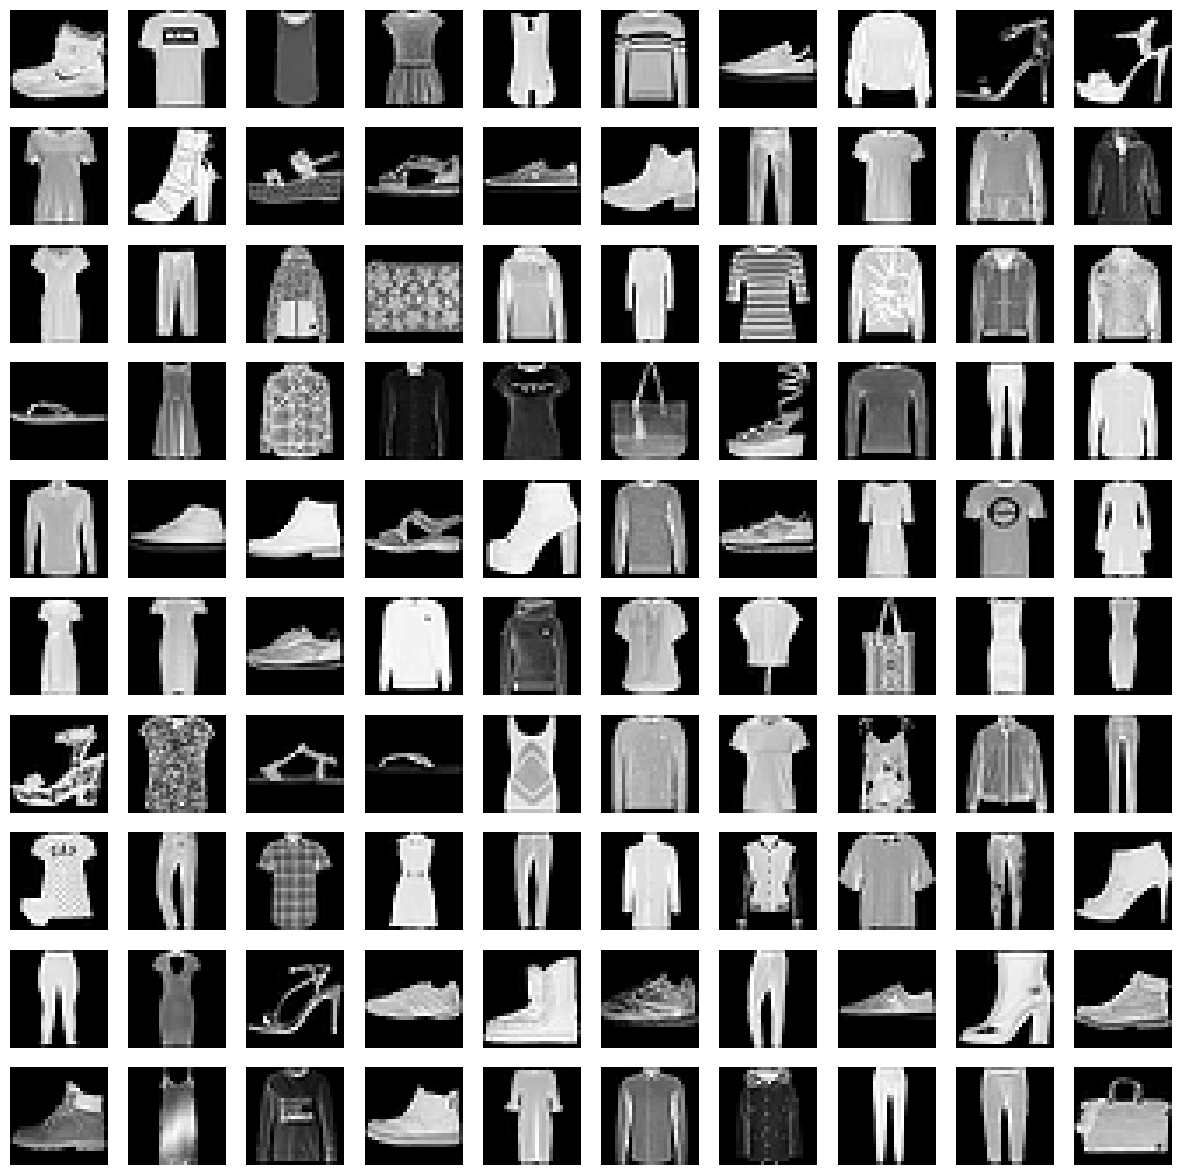

In [30]:
plot_mnist_grid(X_train[:100], 10, 10)

### Echilibrul Setului de Date

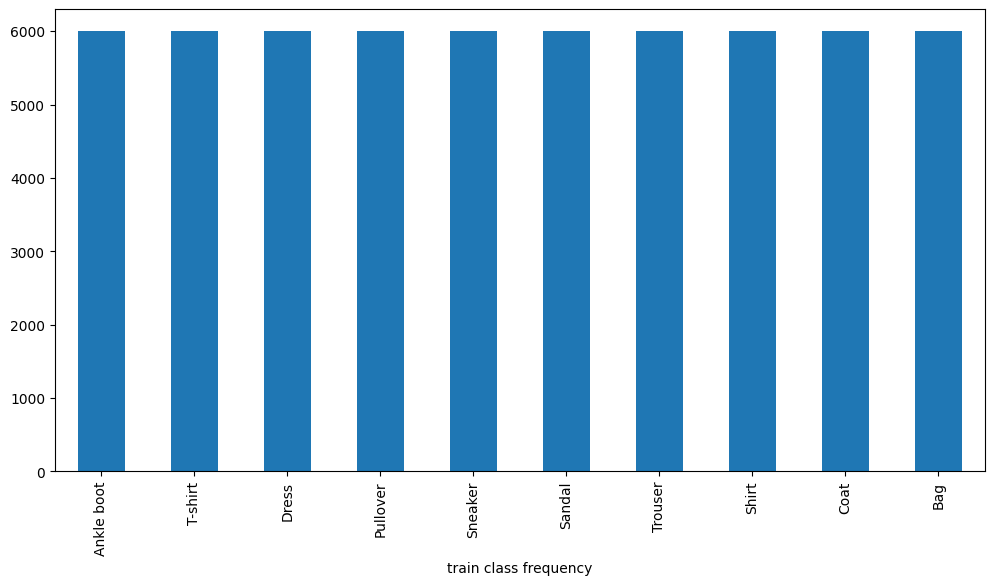

In [6]:
# Vizualizarea echilibrului dater de antrenare
labels = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

mapped_y = [labels[i] for i in y_train]
df = pd.DataFrame(mapped_y, columns=['train class frequency'])
df_freq = df['train class frequency'].value_counts()

ax = df_freq.plot.bar(x='train', y='frequency', rot=90, figsize=(12, 6))

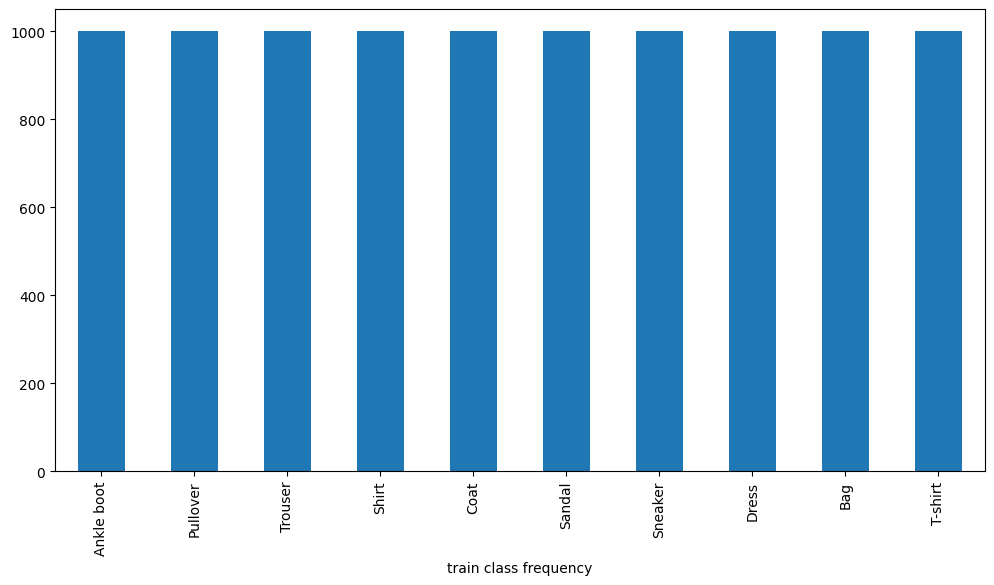

In [7]:
# Vizualizarea echilibrului dater de testare
mapped_y = [labels[i] for i in y_test]
df = pd.DataFrame(mapped_y, columns=['train class frequency'])
df_freq = df['train class frequency'].value_counts()

ax = df_freq.plot.bar(x='train', y='frequency', rot=90, figsize=(12, 6))

### Standardizarea Datelor

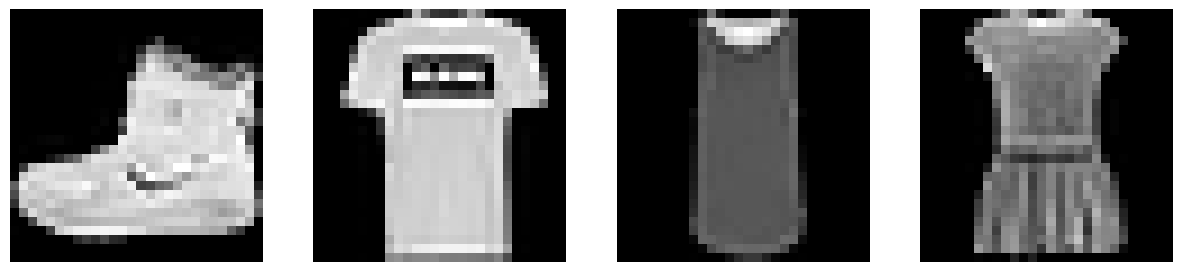

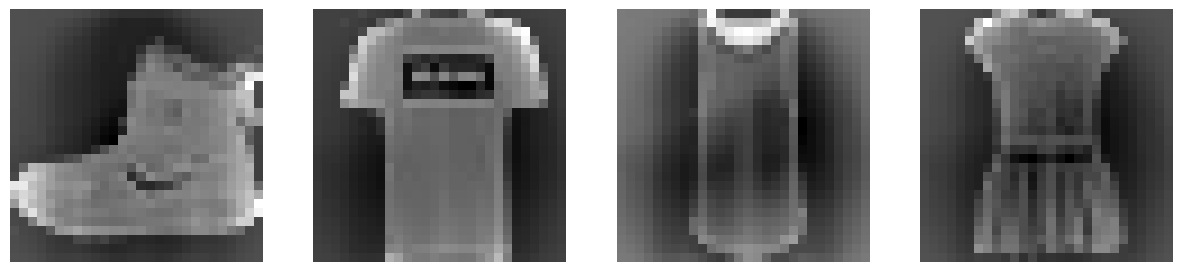

In [12]:
# Scalarea datelor de intrare
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

plot_mnist_grid(X_train[:4], 1, 4)
plot_mnist_grid(X_train_scaled[:4], 1, 4)
X_train = X_train_scaled

# Salvarea datelor pe disk
np.save('data/fashion/X_train', X_train)
np.save('data/fashion/X_test', X_test)

# Eliberarea memoriei
del X_train_scaled, X_train, y_train, X_test, y_test

### Extragerea Atributelor - PCA - del

In [14]:
# Aplicați PCA pe datele de antrenament și testare
X_train = np.load('data/fashion/X_train.npy')
X_test = np.load('data/fashion/X_test.npy')

pca = PCA(n_components=20)
X_train20 = pca.fit_transform(X_train)
X_test20 = pca.transform(X_test)

# Vizualiare PCA
print(X_train.shape)
print(X_train20.shape)

# Salvarea datelor pe disk
np.save('data/fashion/X_train20', X_train20)
np.save('data/fashion/X_test20', X_test20)

# Eliberarea memoriei
del X_train20, X_test20, X_train

(60000, 784)
(60000, 20)


['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


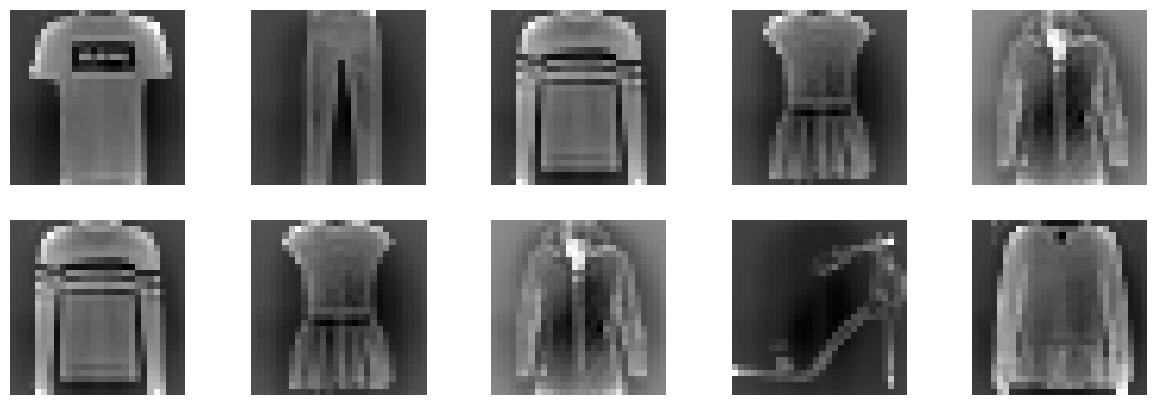

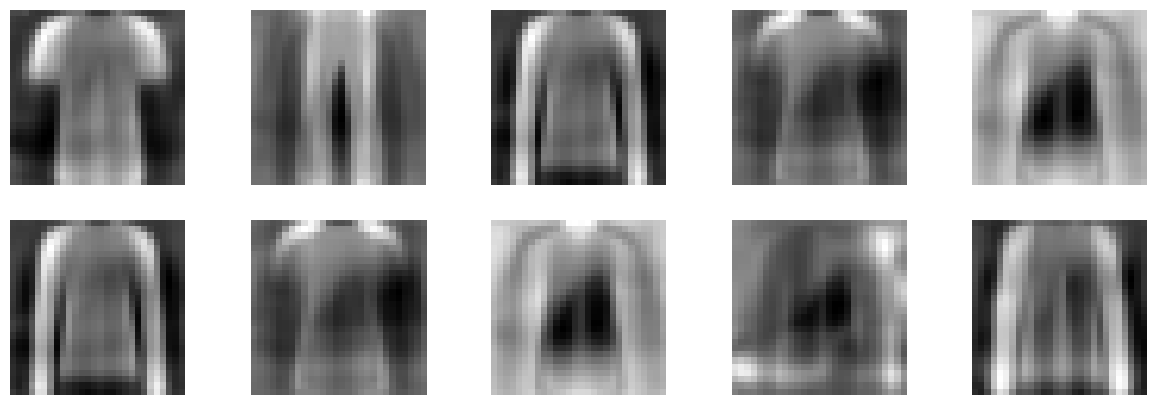

In [15]:
# Vizualizarea atributelor extrase
X_train = np.load('data/fashion/X_train.npy')
X_train20 = np.load('data/fashion/X_train20.npy')
y_train = np.load('data/fashion/y_train.npy')

im_reduced = np.array(list(map(lambda x: pca.inverse_transform(x), X_train20)))
reshaped = np.array(list(map(lambda x: x.reshape(1, -1), im_reduced)))

images =[]
orig_images = []
for label in range(0, 10):
    index = list(y_train).index(label)
    images.append(reshaped[index])
    orig_images.append(X_train[index])

plot_mnist_grid(orig_images, 2, 5, figsize=(15, 5))
plot_mnist_grid(images, 2, 5, figsize=(15, 5))
print(labels)

# Eliberarea memoriei
del X_train, X_train20, im_reduced, reshaped

### Extragerea Atributelor - HOG

In [16]:
# Procesare si vizualizare a algoritmului hog
def resize_image(img):
    resized_img = resize(img, (128, 64))
    return resized_img

# Aplicare hog
def apply_hog(resized_img):
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    return fd, hog_image

In [ ]:
# Procesare a algoritmului hog
X_trainHOG = []
hog_images = []
images = []
img_labels = []
i = 0

# Pregatirea datelor de antrenare
X_train = np.load('data/fashion/X_train.npy')
y_train = np.load('data/fashion/y_train.npy')
X_t = X_train.reshape(60000, 28, 28, 1)

for image in X_t:
    resized_img = resize_image(image)
    fd, hog_image = apply_hog(resized_img)
    X_trainHOG.append(fd)

    if(y_train[i] not in img_labels):
        hog_images.append(hog_image)
        images.append(image)
        img_labels.append(y_train[i])
    i += 1

# Date retinute pentru vizualizare
X_trainHOG = np.array(X_trainHOG)
hog_images = np.array(hog_images)
images = np.array(images)
print("Finished processing training set")

# Aplicam HOG pe setul de testare
X_testHOG = []
X_test = np.load('data/fashion/X_test.npy')
X_t = X_test.reshape(10000, 28, 28, 1)

for image in X_t:
    resized_img = resize_image(image)
    fd, _ = apply_hog(resized_img)
    X_testHOG.append(fd)

X_testHOG = np.array(X_testHOG)

print("Finished processing test set")
print(X_trainHOG.shape)
print(X_testHOG.shape)

# Salvarea datelor pe disk
np.save('data/fashion/X_trainHOG', X_trainHOG)
np.save('data/fashion/X_testHOG', X_testHOG)

# Eliberarea memoriei
del X_trainHOG, X_testHOG, X_train, X_test, y_train

Finished processing test set
(60000, 3780)
(10000, 3780)


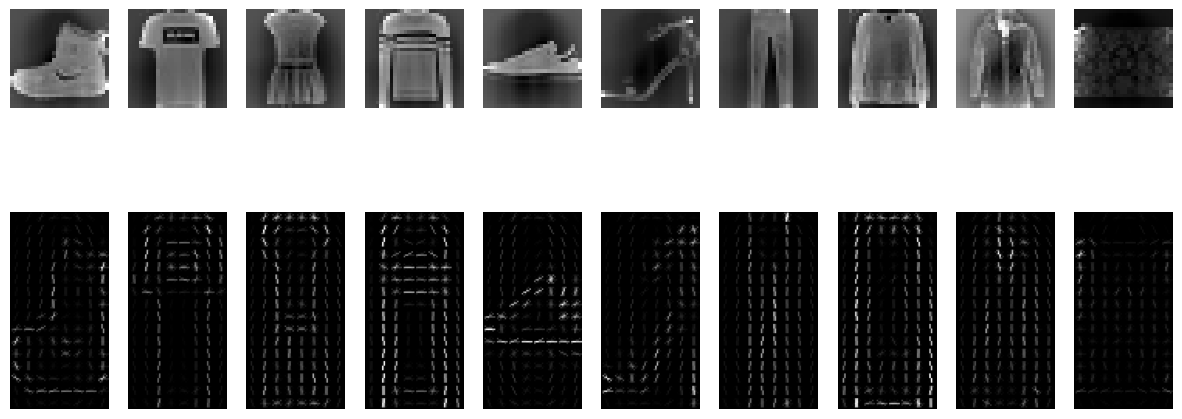

In [20]:
# Vizualizare atribute extrase
size = len(images)
fig, axs = plt.subplots(2, size, figsize=(15, 6))
for i in range(size):
    first_image = np.array(images[i])
    pixels = first_image.reshape((28, 28))

    axs[0, i].axis('off')
    axs[0, i].imshow(pixels, cmap="gray")
    axs[1, i].axis('off')
    axs[1, i].imshow(hog_images[i], cmap="gray")

### Extragerea Atributelor - PCA

In [3]:
# Aplicați PCA pe datele de antrenament și testare
X_train = np.load('data/fashion/X_trainHOG.npy')
X_test = np.load('data/fashion/X_testHOG.npy')

pca = PCA(n_components=20)
X_train20 = pca.fit_transform(X_train)
X_test20 = pca.transform(X_test)

# Vizualiare PCA
print(X_train.shape)
print(X_train20.shape)

# Salvarea datelor pe disk
np.save('data/fashion/X_train20_HOG', X_train20)
np.save('data/fashion/X_test20_HOG', X_test20)

# Eliberarea memoriei
del X_train20, X_test20, X_train

(60000, 3780)
(60000, 20)


ValueError: cannot reshape array of size 3780 into shape (28,28)

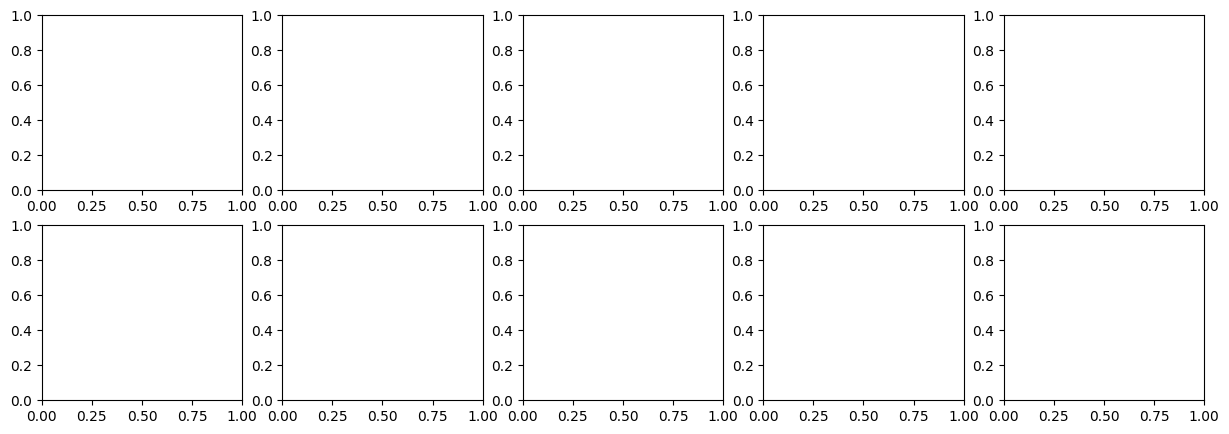

In [ ]:
# Vizualizarea atributelor extrase
X_train = np.load('data/fashion/X_train.npy')
X_train20 = np.load('data/fashion/X_train20_HOG.npy')
y_train = np.load('data/fashion/y_train.npy')

im_reduced = np.array(list(map(lambda x: pca.inverse_transform(x), X_train20[:100])))
reshaped = np.array(list(map(lambda x: x.reshape(1, -1), im_reduced)))
X_train = X_train[:100]

images =[]
orig_images = []
for label in range(0, 10):
    index = list(y_train).index(label)
    images.append(reshaped[index])
    orig_images.append(X_train20[index])

# plot_mnist_grid(orig_images, 2, 5, figsize=(15, 5))
# plot_mnist_grid(images, 2, 5, figsize=(15, 5))
# print(labels)

# Vizualizare atribute extrase
size = len(images)
fig, axs = plt.subplots(1, size, figsize=(15, 6))
for i in range(size):
    first_image = np.array(images[i])

    axs[i].axis('off')
    axs[i].imshow(first_image, cmap="gray")

# Eliberarea memoriei
del X_train, X_train20, im_reduced, reshaped

### Selectia Atributelor

In [ ]:
sel_variance = VarianceThreshold(threshold=0.03)
sel_percentile = SelectPercentile(percentile=80)

In [ ]:
X_train20 = np.load('data/fashion/X_train20_HOG.npy')
X_test20 = np.load('data/fashion/X_test20_HOG.npy')
y_train = np.load('data/fashion/y_train.npy')
y_test = np.load('data/fashion/y_test.npy')

print(f'PCA: X shape before applying variance threashold: {X_train20.shape}')
X_train20 = sel_variance.fit_transform(X_train20)
print(f'PCA: X shape after applying variance threashold: {X_train20.shape}')

X_train20 = sel_percentile.fit_transform(X_train20, y_train)
X_test20 = sel_percentile.transform(X_test20)
print(f'PCA: X shape after applying percentile selector: {X_train20.shape}')

# Salvarea datelor pe disk
np.save('data/fashion/X_train20_scaled', X_train20)
np.save('data/fashion/X_test20_scaled', X_test20)
del X_train20, X_test20, y_test

PCA: X shape before applying variance threashold: (60000, 20)
PCA: X shape after applying variance threashold: (60000, 20)
PCA: X shape after applying percentile selector: (60000, 16)


In [ ]:
# Incarcare date
X_train20 = np.load('data/fashion/X_train20_scaled.npy')
y_train = np.load('data/fashion/y_train.npy')

# Impartirea setului de date
X_train_final_pca, X_validation_pca, y_train_final_pca, y_validation_pca = train_test_split(X_train20, y_train) 

# Salvarea datelor pe disk
np.save('data/fashion/X_train_final_pca', X_train_final_pca)
np.save('data/fashion/X_validation_pca', X_validation_pca)
np.save('data/fashion/y_train_final_pca', y_train_final_pca)
np.save('data/fashion/y_validation_pca', y_validation_pca)

# Eliberare memorie
del X_train_final_pca, X_validation_pca, y_train_final_pca, y_validation_pca, y_train, X_train20

### Antrenarea Modelelor

In [47]:
# Incarcarea datelor
X_train_final_pca = np.load('data/fashion/X_train_final_pca.npy')
X_validation_pca = np.load('data/fashion/X_validation_pca.npy')
y_train_final_pca = np.load('data/fashion/y_train_final_pca.npy')
y_validation_pca = np.load('data/fashion/y_validation_pca.npy')
X_test20_HOG = np.load('data/fashion/X_test20_scaled.npy')
y_test = np.load('data/fashion/y_test.npy')

##### Logistic Regresion

In [49]:
# Hyperparameter Tunning
param_grid = [
    {'penalty':['l1','l2'],
    'C' : [0.1, 1, 0.01],
    'solver': ['liblinear'],
    'max_iter'  : [500, 1000],
    'multi_class' : ['ovr']
    },
    {'penalty':['l2'],
    'C' : [0.1, 1, 0.01],
    'solver': ['lbfgs', 'newton-cg', 'sag'],
    'max_iter'  : [500, 1000],
    'multi_class' : ['ovr', 'multinomial']
    },
    {'penalty':['elasticnet'],
    'C' : [0.1, 1, 0.01],
    'solver': ['saga'],
    'max_iter'  : [500, 1000],
    'l1_ratio' : [0, 0.1, 0.5],
    'multi_class' : ['ovr', 'multinomial']
    }
]

grid = GridSearchCV(LogisticRegression(), param_grid, scoring='accuracy', n_jobs=-1)
grid.fit(X_validation_pca, y_validation_pca)

# Training model
model = grid.best_estimator_
model.fit(X_train_final_pca, y_train_final_pca)
y_pred = model.predict(X_test20_HOG)

/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: Future

In [50]:
# Evaluare model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Logistic Regression considering first 20PC: {0:.2f}% \n".format(precision))

Accuracy with Logistic Regression considering first 20PC: 80.97% 



In [51]:
# Defining custom function which returns
def highlight_max(s): 
    is_max = s == s.max() 
    return ['color: green; font-weight: bold;' if cell else '' for cell in is_max] 

# Tabel cu parametrii
df = pd.DataFrame(grid.cv_results_)
df = df[['param_penalty', 'param_C', 'param_solver', 'param_max_iter', 'param_multi_class', 'mean_test_score']]
df = df.sort_values(by='mean_test_score', ascending=False)

# Aplicare highlight
df_styled = df.style.apply(highlight_max).hide(axis="index")
df_styled

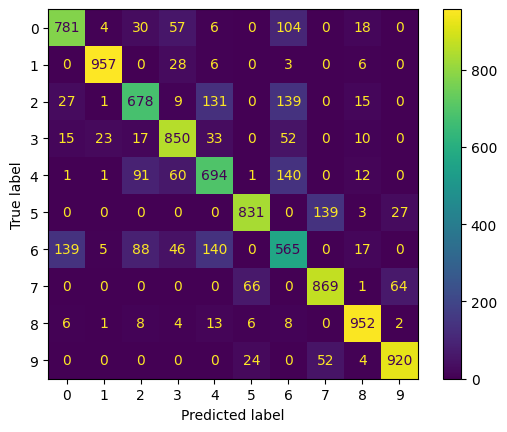

In [52]:
# Matrice de confuzie
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

##### SMV

In [29]:
# Hyperparameter Tunning
param_grid = {'C': [1, 10, 30],
              'kernel': ['poly', 'rbf']
            }
grid = GridSearchCV(SVC(), param_grid, refit = True, scoring='accuracy', n_jobs=-1)
grid.fit(X_validation_pca, y_validation_pca)

# Training model
model = grid.best_estimator_
model.fit(X_train_final_pca, y_train_final_pca)
y_pred = model.predict(X_test20_HOG)

In [30]:
# Evaluare model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Logistic Regression considering first 20PC: {0:.2f}% \n".format(precision))

Accuracy with Logistic Regression considering first 20PC: 87.54% 



In [31]:
def highlight_max(s): 
    is_max = s == s.max() 
    return ['color: green; font-weight: bold;' if cell else '' for cell in is_max] 

# Tabel cu parametrii
df = pd.DataFrame(grid.cv_results_)
df = df[['param_C', 'param_kernel', 'mean_test_score']]
df = df.sort_values(by='mean_test_score', ascending=False)

# Aplicare highlight
df_styled = df.style.apply(highlight_max).hide(axis="index")
df_styled

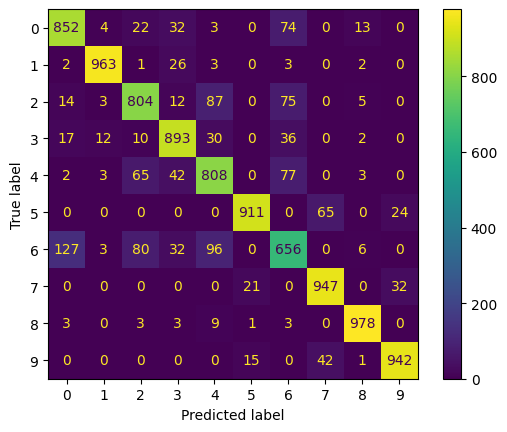

In [32]:
# Matrice de confuzie
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

##### Random Forest

In [34]:
# Hyperparameter Tunning
param_grid = { 
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 8, 12, None],
    'max_samples': [0.3, 0.7, 1.0, None]
} 

grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring='accuracy', n_jobs=-1)
grid.fit(X_validation_pca, y_validation_pca)

# Training model
model = grid.best_estimator_
model = model.fit(X_train_final_pca, y_train_final_pca)
y_pred = model.predict(X_test20_HOG)

In [35]:
# Evaluare model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Logistic Regression considering first 20PC: {0:.2f}% \n".format(precision))

Accuracy with Logistic Regression considering first 20PC: 85.43% 



In [36]:
def highlight_max(s): 
    is_max = s == s.max() 
    return ['color: green; font-weight: bold;' if cell else '' for cell in is_max] 

# Tabel cu parametrii
df = pd.DataFrame(grid.cv_results_)
df = df[['param_n_estimators', 'param_max_depth', 'param_max_samples', 'mean_test_score']]
df = df.sort_values(by='mean_test_score', ascending=False)

# Aplicare highlight
df_styled = df.style.apply(highlight_max).hide(axis="index")
df_styled

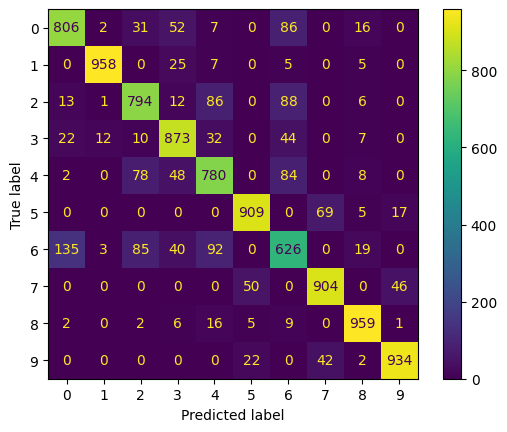

In [37]:
# Matrice de confuzie
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

##### Gradient Boosted Trees

In [39]:
# Hyperparameter Tunning
param_grid = {
    "max_depth": [2, 4, 6], 
    "num_parallel_tree": [1, 3, 5],
    "eta": [0.15, 0.3, 0.45]
}
grid = GridSearchCV(
    xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()),
    param_grid,
    scoring='accuracy',
    n_jobs=-1,
)
grid.fit(X_validation_pca, y_validation_pca)

# Training model 
model = grid.best_estimator_
model = model.fit(X_train_final_pca, y_train_final_pca)
y_pred = model.predict(X_test20_HOG)

In [40]:
# Evaluare model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Logistic Regression considering first 20PC: {0:.2f}% \n".format(precision))

Accuracy with Logistic Regression considering first 20PC: 85.83% 



In [41]:
def highlight_max(s): 
    is_max = s == s.max() 
    return ['color: green; font-weight: bold;' if cell else '' for cell in is_max] 

# Tabel cu parametrii
df = pd.DataFrame(grid.cv_results_)
df = df[['param_max_depth', 'param_num_parallel_tree', 'param_eta', 'mean_test_score']]
df = df.sort_values(by='mean_test_score', ascending=False)

# Aplicare highlight
df_styled = df.style.apply(highlight_max).hide(axis="index")
df_styled

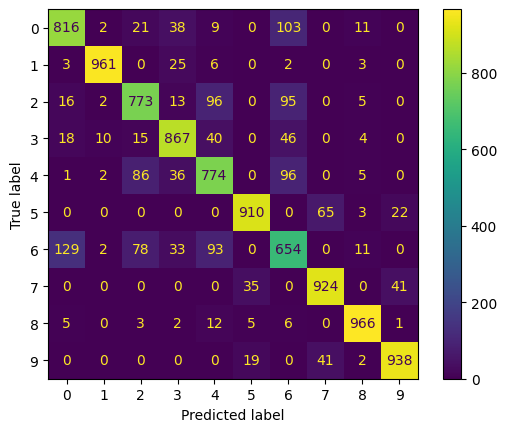

In [42]:
# Matrice de confuzie
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

In [53]:
del X_train_final_pca, X_validation_pca, y_train_final_pca, y_validation_pca, X_test20_HOG, y_test